In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

# Base libraries
import os
import random

# Keras libraries
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, BatchNormalization, UpSampling2D
from keras.layers import  Dropout, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils import plot_model

print(tf.__version__)

2.1.0


Using TensorFlow backend.


# 유틸

In [2]:
def save_model(model_name: str, model: keras.models.Model):
    model_json = model.to_json()
    with open(model_name, "w") as json_file:
        json_file.write(model_json)

from keras.models import model_from_json
from typing import Optional

In [3]:
def load_model(
    model_name: str, with_weights_path: Optional[str] = None) -> keras.models.Model:
    json_file = open(model_name, "r")
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    if with_weights_path:
        model.load_weights(with_weights_path)
    return model

In [ ]:
# 구글 드라이브 import
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

import os
gdrive_path = os.path.join("/gdrive", "My Drive", "lecture", "resources")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /gdrive


# Dataset

## 다운로드

In [ ]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xvzf images.tar.gz && tar -xvzf annotations.tar.gz
!rm  images/*.mat

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian_190.png
annotations/trimaps/._pomeranian_191.png
annota

In [ ]:
# cv2가 처리하지 못하는 파일 삭제

!rm -f images/Egyptian_Mau_177.jpg
!rm -f annotations/trimaps/Egyptian_Mau_177.jpg

!rm -f images/Egyptian_Mau_191.jpg
!rm -f annotations/trimaps/Egyptian_Mau_191.jpg

!rm -f images/Egyptian_Mau_139.jpg
!rm -f annotations/trimaps/Egyptian_Mau_139.jpg

!rm -f images/Egyptian_Mau_145.jpg
!rm -f annotations/trimaps/Egyptian_Mau_145.jpg

!rm -f images/Egyptian_Mau_167.jpg
!rm -f annotations/trimaps/Egyptian_Mau_167.jpg

!rm -f images/Abyssinian_34.jpg
!rm -f annotations/trimaps/Abyssinian_34.jpg

## 확인

In [ ]:
import cv2
import os

# 다양한 크기

mask = cv2.imread(os.path.join("annotations", "trimaps", "Abyssinian_2.png"))
print(mask.shape)

img = cv2.imread(os.path.join("images", "Abyssinian_2.jpg"))
print(img.shape)

resized_img = cv2.resize(img, (256, 256))
print(resized_img.shape)

# 이미지와 마스크가 서로 다른 파일 개수

print(len(os.listdir(os.path.join("annotations", "trimaps"))))
print(len(os.listdir(os.path.join("images"))))

# 이미지는 jpg, 마스크는 png.

len(list(filter(lambda el: el[-3:] == "png", os.listdir(os.path.join("annotations", "trimaps")))))

# 이미지는 color. 마스크는 grayscale.

(473, 600, 3)
(473, 600, 3)
(256, 256, 3)
14780
7390


14780

# U-Net

## 준비

In [ ]:
batch_size = 32
seed = 42

In [ ]:
# from keras.preprocessing.image import ImageDataGenerator

# img_generator = ImageDataGenerator()
# img_generator.flow_from_directory(
#     ".", 
#     classes=["images"], 
#     target_size=(256, 256), 
#     batch_size=batch_size,
#     color_mode="grayscale",
#     interpolation="nearest",
#     class_mode=None,
#     shuffle=True,
#     seed=42)

# mask_generator = ImageDataGenerator()
# mask_generator.flow_from_directory(
#     "annotations", 
#     classes=["trimaps"], 
#     target_size=(256, 256), 
#     batch_size=batch_size,
#     color_mode="grayscale",
#     interpolation="nearest",
#     class_mode=None,
#     shuffle=True,
#     seed=42)

## Generator 만들기

### Generator 생성

In [ ]:
image_files = os.listdir("images")
image_names = list(map(lambda v: v[:-4], image_files))

random.seed(seed)
random.shuffle(image_names)

split = int(0.95 * len(image_names))
train_image_names = image_names[0:split]
test_image_names  = image_names[split:]

val_split = int(0.9 * len(train_image_names))
val_image_names = train_image_names[val_split:]
train_image_names = train_image_names[0:val_split]

In [ ]:
import toolz
import numpy as np

def img_mask_generator(img_path, mask_path, image_files, mask_files, batch_size=1, target_size=(256, 256)):
  total_file_num = len(image_files)
  index = -1
  while True:
    index = 0 if index > ((total_file_num // batch_size) - 2) else index+1
    img_batch = []
    mask_batch = []
    
    for i in range(batch_size):
      img = cv2.imread(os.path.join(img_path, image_files[batch_size*index+i]), cv2.IMREAD_COLOR)
      img = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST)

      img = img / 255.

      img_batch.append(img)
      
      mask = cv2.imread(os.path.join(mask_path, mask_files[batch_size*index+i]), cv2.IMREAD_GRAYSCALE)
      mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

      mask[mask >= 2] = 0
      mask[mask != 0] = 1
      
      mask = np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
      mask_batch.append(mask)

    yield np.array(img_batch), np.array(mask_batch)

with_ext = lambda v, ext: "{}.{}".format(v, ext)

In [ ]:
train_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), train_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), train_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

val_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), val_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), val_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

test_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), test_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), test_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

### 샘플 이미지 플롯

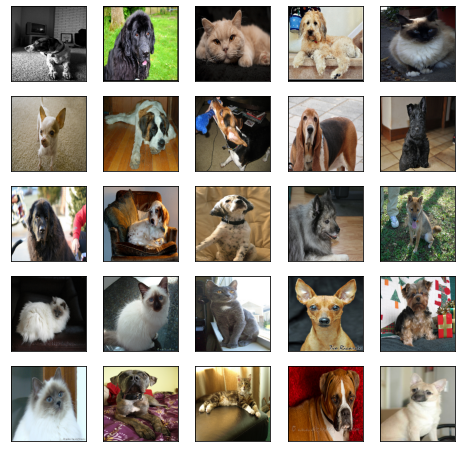

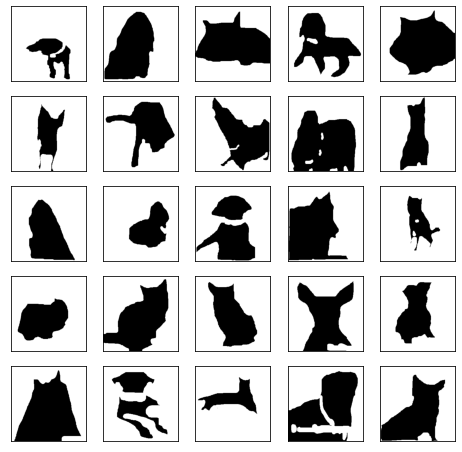

In [ ]:
plt.figure(figsize=(8, 8))

img_mask_batch = next(train_batch_generator)

for i in range(25):
  _img = np.float32(img_mask_batch[0][i])
  _img = cv2.cvtColor(_img, cv2.COLOR_BGR2RGB)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(_img, cmap=plt.cm.binary)
plt.show()

plt.figure(figsize=(8, 8))

for i in range(25):
  _mask = np.reshape(img_mask_batch[1][i], (256, 256))

  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(_mask, cmap=plt.cm.binary)
plt.show()


### Generator 초기화

In [ ]:
train_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), train_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), train_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

val_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), val_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), val_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

test_batch_generator = img_mask_generator(
    img_path=os.path.join("images"),
    mask_path=os.path.join("annotations", "trimaps"),
    image_files=list(map(lambda v: with_ext(v, "jpg"), test_image_names)),
    mask_files=list(map(lambda v: with_ext(v, "png"), test_image_names)),
    batch_size=batch_size,
    target_size=(256, 256))

## 모델

### 모델 생성

$$IoU = \frac{y_{true} \cap y_{pred}}{y_{true} \cup y_{pred}}$$

In [ ]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = K.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

In [ ]:
def unet(sz = (256, 256, 3)):
  x = Input(sz)
  inputs = x
  
  # down sampling 
  f = 8
  layers = []
  
  for i in range(0, 6):
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    layers.append(x)
    x = MaxPooling2D() (x)
    f = f*2
  ff2 = 64 
  
  # bottleneck 
  j = len(layers) - 1
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
  x = Concatenate(axis=3)([x, layers[j]])
  j = j -1 
  
  # upsampling 
  for i in range(0, 5):
    ff2 = ff2//2
    f = f // 2 
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2D(f, 3, activation='relu', padding='same') (x)
    x = Conv2DTranspose(ff2, 2, strides=(2, 2), padding='same') (x)
    x = Concatenate(axis=3)([x, layers[j]])
    j = j -1 
    
  
  # classification 
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  x = Conv2D(f, 3, activation='relu', padding='same') (x)
  outputs = Conv2D(1, 1, activation='sigmoid') (x)
  
  # model creation 
  model = Model(inputs=[inputs], outputs=[outputs])
  model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = [mean_iou])
  
  return model

In [ ]:
model = unet()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 256, 256, 8)  224         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 256, 256, 8)  584         conv2d_27[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 128, 128, 8)  0           conv2d_28[0][0]                  
_______________________________________________________________________________________

### 모델 트레이닝

In [ ]:
def build_callbacks():
        checkpointer = ModelCheckpoint(filepath='unet.h5', verbose=0, save_best_only=True, save_weights_only=True)
        callbacks = [checkpointer, PlotLearning()]
        return callbacks

val_image_list = list(map(lambda v: with_ext(v, "jpg"), val_image_names))

# inheritance for training process plot 
class PlotLearning(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.acc = []
        self.val_acc = []
        #self.fig = plt.figure()
        self.logs = []
        
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('mean_iou'))
        self.val_acc.append(logs.get('val_mean_iou'))
        self.i += 1
        # print('i=',self.i,'loss=',logs.get('loss'),'val_loss=',logs.get('val_loss'),'mean_iou=',logs.get('mean_iou'),'val_mean_iou=',logs.get('val_mean_iou'))
        
        # choose a random test image and preprocess
        path = np.random.choice(val_image_list)
        img = cv2.imread(f'images/{path}')
        img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
        img = img / 255.

        target_mask = cv2.imread(os.path.join("annotations", "trimaps", "{}.png".format(path[:-4])))
        target_mask = cv2.resize(target_mask, (256, 256), interpolation=cv2.INTER_NEAREST)
        target_mask[target_mask >= 2] = 0
        target_mask[target_mask != 0] = 1
        
        # predict the mask 
        pred = model.predict(np.expand_dims(img, 0))
        
        # mask post-processing 
        msk = pred.squeeze()
        msk = np.stack((msk,)*3, axis=-1)
        msk[msk >= 0.5] = 1 
        msk[msk < 0.5] = 0 
        
        # show the mask and the segmented image 
        img = img.astype(np.float32) 
        rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        combined = np.concatenate([rgb_img, msk, rgb_img * msk, target_mask], axis = 1)
        plt.axis('off')
        plt.imshow(combined)
        plt.show()

Epoch 1/10
197/197 [==============================] - ETA: 0s - loss: 0.2290 - mean_iou: 0.7307

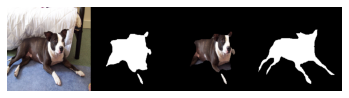

197/197 [==============================] - 52s 266ms/step - loss: 0.2290 - mean_iou: 0.7307 - val_loss: 0.2614 - val_mean_iou: 0.7005
Epoch 2/10
197/197 [==============================] - ETA: 0s - loss: 0.2144 - mean_iou: 0.7467

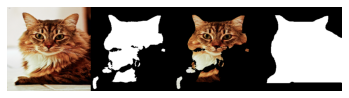

197/197 [==============================] - 52s 262ms/step - loss: 0.2144 - mean_iou: 0.7467 - val_loss: 0.2500 - val_mean_iou: 0.7010
Epoch 3/10
197/197 [==============================] - ETA: 0s - loss: 0.2002 - mean_iou: 0.7622

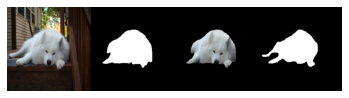

197/197 [==============================] - 51s 259ms/step - loss: 0.2002 - mean_iou: 0.7622 - val_loss: 0.2296 - val_mean_iou: 0.7245
Epoch 4/10
197/197 [==============================] - ETA: 0s - loss: 0.1878 - mean_iou: 0.7755

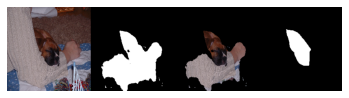

197/197 [==============================] - 51s 260ms/step - loss: 0.1878 - mean_iou: 0.7755 - val_loss: 0.2126 - val_mean_iou: 0.7308
Epoch 5/10
197/197 [==============================] - ETA: 0s - loss: 0.1776 - mean_iou: 0.7870

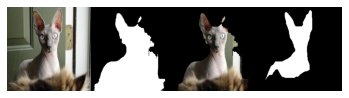

197/197 [==============================] - 52s 262ms/step - loss: 0.1776 - mean_iou: 0.7870 - val_loss: 0.2390 - val_mean_iou: 0.7228
Epoch 6/10
197/197 [==============================] - ETA: 0s - loss: 0.1691 - mean_iou: 0.7965

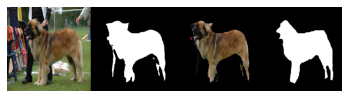

197/197 [==============================] - 51s 259ms/step - loss: 0.1691 - mean_iou: 0.7965 - val_loss: 0.2144 - val_mean_iou: 0.7489
Epoch 7/10
197/197 [==============================] - ETA: 0s - loss: 0.1592 - mean_iou: 0.8076

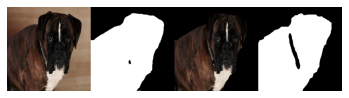

197/197 [==============================] - 51s 259ms/step - loss: 0.1592 - mean_iou: 0.8076 - val_loss: 0.2326 - val_mean_iou: 0.7467
Epoch 8/10
197/197 [==============================] - ETA: 0s - loss: 0.1528 - mean_iou: 0.8153

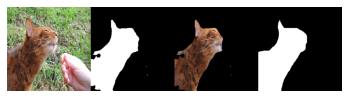

197/197 [==============================] - 51s 257ms/step - loss: 0.1528 - mean_iou: 0.8153 - val_loss: 0.2214 - val_mean_iou: 0.7357
Epoch 9/10
197/197 [==============================] - ETA: 0s - loss: 0.1425 - mean_iou: 0.8253

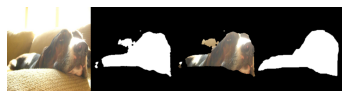

197/197 [==============================] - 51s 259ms/step - loss: 0.1425 - mean_iou: 0.8253 - val_loss: 0.2269 - val_mean_iou: 0.7281
Epoch 10/10
197/197 [==============================] - ETA: 0s - loss: 0.1400 - mean_iou: 0.8290

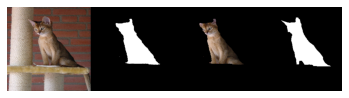

197/197 [==============================] - 51s 260ms/step - loss: 0.1400 - mean_iou: 0.8290 - val_loss: 0.2079 - val_mean_iou: 0.7557


In [ ]:
train_steps = len(train_image_names) // batch_size
val_steps = len(val_image_names) // batch_size

history = model.fit(
    train_batch_generator,
    epochs = 10,
    steps_per_epoch = train_steps,
    validation_data = val_batch_generator, 
    validation_steps = val_steps,
    callbacks = build_callbacks(), 
    verbose = 1)

[0.7306967973709106, 0.7466645240783691, 0.7622091770172119, 0.7755338549613953, 0.786993682384491, 0.7965213656425476, 0.8076218962669373, 0.8152846097946167, 0.8253448605537415, 0.8290383815765381]
[0.7004629373550415, 0.7010347843170166, 0.7244865894317627, 0.7308477759361267, 0.7228224873542786, 0.7488789558410645, 0.746658444404602, 0.7357454895973206, 0.7280529141426086, 0.7557238340377808]


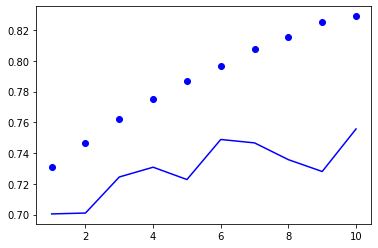

In [ ]:
history_accuracy = history.history["mean_iou"]
history_val_accuracy = history.history["val_mean_iou"]

epochs = range(1, len(history_accuracy) + 1)
plt.plot(epochs, history_accuracy, "bo", label="Training accuracy")
plt.plot(epochs, history_val_accuracy, "b", label="Validation accuracy")

print(history_accuracy)
print(history_val_accuracy)

[0.22896234691143036, 0.2144242525100708, 0.2001739740371704, 0.18781667947769165, 0.17764289677143097, 0.16906194388866425, 0.15924882888793945, 0.1527508944272995, 0.14245308935642242, 0.14002709090709686]
[0.2613896429538727, 0.24995388090610504, 0.22960099577903748, 0.21258072555065155, 0.23904716968536377, 0.21435916423797607, 0.23258495330810547, 0.22143810987472534, 0.22689342498779297, 0.20794394612312317]


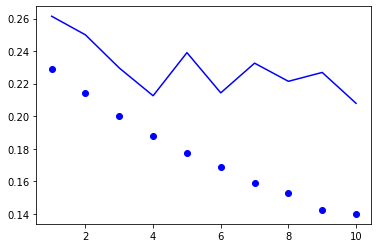

In [ ]:
history_loss = history.history["loss"]
history_val_loss = history.history["val_loss"]

epochs = range(1, len(history_loss) + 1)
plt.plot(epochs, history_loss, "bo", label="Training loss")
plt.plot(epochs, history_val_loss, "b", label="Validation loss")

print(history_loss)
print(history_val_loss)

### 모델 테스트 및 예측

In [ ]:
test_steps = len(test_image_names) // batch_size
test_loss, test_acc = model.evaluate(test_batch_generator, steps=test_steps, verbose=2)
print('테스트 정확도:', test_acc)

11/11 - 2s - loss: 0.1933 - mean_iou: 0.7698
테스트 정확도: 0.7697839736938477


In [1]:
!wget http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg -O test.jpg

--2020-09-09 07:21:00--  http://r.ddmcdn.com/s_f/o_1/cx_462/cy_245/cw_1349/ch_1349/w_720/APL/uploads/2015/06/caturday-shutterstock_149320799.jpg
Resolving r.ddmcdn.com (r.ddmcdn.com)... 13.224.11.23, 13.224.11.94, 13.224.11.106, ...
Connecting to r.ddmcdn.com (r.ddmcdn.com)|13.224.11.23|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 63219 (62K) [image/jpeg]
Saving to: ‘test.jpg’

test.jpg            100%[===================>]  61.74K  --.-KB/s    in 0.01s   

2020-09-09 07:21:00 (5.46 MB/s) - ‘test.jpg’ saved [63219/63219]



In [5]:
import cv2
img = cv2.imread('t/test.jpg')
img.shape

(720, 720, 3)

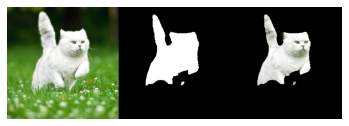

In [ ]:
img = cv2.imread('test.jpg')
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# predict the mask 
pred = model.predict(np.expand_dims(img, 0))

# mask post-processing 
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

# show the mask and the segmented image
img = img.astype(np.float32) 
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
combined = np.concatenate([rgb_img, msk, rgb_img * msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()

### 모델 저장

In [ ]:
save_model(os.path.join(gdrive_path, "unet_000.json"), model)

import time
run_id: str = time.strftime("%Y%m%d-%H%M%S")
model.save_weights(os.path.join(gdrive_path, "unet_000__{}.hdf5".format(run_id)))

In [ ]:
json_model_path = os.path.join(gdrive_path, "unet_000.json")
model_weight_path = os.path.join(gdrive_path, "unet_000__20200906-074932.hdf5")
loaded_model2_with_weight = load_model(json_model_path, model_weight_path)

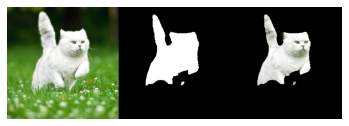

In [ ]:
img = cv2.imread('test.jpg')
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_NEAREST)
img = img / 255.

# predict the mask 
pred = loaded_model2_with_weight.predict(np.expand_dims(img, 0))

# mask post-processing 
msk = pred.squeeze()
msk = np.stack((msk,)*3, axis=-1)
msk[msk >= 0.5] = 1 
msk[msk < 0.5] = 0 

# show the mask and the segmented image
img = img.astype(np.float32) 
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
combined = np.concatenate([rgb_img, msk, rgb_img * msk], axis = 1)
plt.axis('off')
plt.imshow(combined)
plt.show()